<div style="text-align: left;">
<font size="4">1.モジュールのインポート</font>
</div>
<pre>
主に使用しているのは
Keras, Tensorflow:ディープラーニングフレームワーク
(KerasのバックエンドでTensorflowを動かします)
Numpy:画像データを行列データにする際に使用
Matplotlib:学習中のグラフを描画するのに使用
Pandas:結果データをまとめるのに使用
</pre>

In [134]:
from keras import backend as K
if 'tensorflow' == K.backend():
    import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))
import keras.backend.tensorflow_backend 
from keras.backend.tensorflow_backend import set_session

import keras, os, glob
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from IPython.display import display
import time


<div style="text-align: left;">
<font size="4">2.ファイルのインポート</font>
</div>
<pre>
本プログラムを配置したディレクトリ以下にフォルダを作成して下さい。
・学習ファイルの配置方法
./IVI_cifar10/train/'クラス1'/'画像ファイル1'.jpg、・・・・'画像ファイル10'.jpg・・・・
                    'クラス2'/'画像ファイル1'.jpg、・・・・・・・・・・・・・・・・・・
                    'クラス3'/・・・・・
　　        　          ・
                        ・
・評価ファイルの配置方法
./IVI_cifar10/test/'クラス1'/'画像ファイル1'.jpg、・・・・'画像ファイル10'.jpg・・・・
                   'クラス2'/'画像ファイル1'.jpg、・・・・・・・・・・・・・・・・・・
                   'クラス3'/・・・・・
          　          ・
                      ・
本プログラムは学習ファイルが格納されている、それぞれのディレクトリ数(クラス1, クラス2、、、)
の数をカウントして分類分けしますので、分類数>=評価分類数として下さい。
ディレクトリの名前は任意ですが、学習と評価ファイルが格納されるディレクトリの名前は一致して下さい。
○クラス1 = クラス1、×クラス1 = class1
</pre>

In [135]:
train_dir = 'C:\\Users\\\ADSTEC\\DLTEST\\cifar10\\IVI_cifar10_2\\train' # 学習データ置き場
train_folder = os.listdir(train_dir)
test_dir = 'C:\\Users\\ADSTEC\\DLTEST\\cifar10\\IVI_cifar10_2\\test' # 評価データ置き場
test_folder = os.listdir(test_dir)

image_size_x = 32 # 元画像サイズX
image_size_y = 32 # 元画像サイズY

X_train = [] # 学習に使う画像データの格納先
Y_train = [] # 学習に使うラベルデータの格納先
X_test = [] # 評価に使う画像データの格納先
Y_test = [] # 評価に使うラベルデータの格納先

# 学習クラス数を取得(学習ディレクリ名から)
class_folder = tuple(train_folder)
class_dict = {}
for i in range(len(train_folder)):
    class_dict[class_folder[i]] = i

# 学習ファイル用データ抜き出し
train_pics = []
for x, name in enumerate(train_folder):
    train_files = glob.glob((train_dir + '\\' + name) + "/*")
    for i,file in enumerate(train_files, start=1):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size_x, image_size_y))
        data = np.asarray(image)
        X_train.append(data)
        index = class_dict[name]   
        Y_train.append(index)
    train_pics.append(i)
if x >= 1:
    train_pics = sum(train_pics)
else:
    train_pics = train_pics

# 評価ファイル用データ抜き出し
test_pics = []
for x,name in enumerate(test_folder):
    test_files = glob.glob((test_dir + '\\' + name) + "/*")
    for i,file in enumerate(test_files, start=1):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size_x, image_size_y))
        data = np.asarray(image)
        X_test.append(data)
        index = class_dict[name] 
        Y_test.append(index) 
        test_pics.append(i)
if x >= 1:
    test_pics = sum(test_pics)
else:
    test_pics = test_pics[0]
print('学習に使用する枚数は',train_pics,'枚')
print('評価に使用する枚数は',test_pics,'枚')

学習に使用する枚数は 180 枚
評価に使用する枚数は 1 枚


<div style="text-align: left;">
<font size="4">3.画像データ変換</font>
</div>
<pre>
・取り込んだ画像データをリストデータから、アレイデータへ変換する。
・8bit諧調の画像として、0-1でのデータ取り扱いをする為に、255で割る。
  (代表として、255で割る前後の数値を下に示します、学習画像1枚目中の1列目,1行目のピクセルを表示)
・各画像にタグ付けされたクラスデータをベクトルデータに変換する(ワンホット表現といいます)
　(全クラス数の行列を作ってあげて、どこにクラス分けされるかを作ります)
 　例：全てのクラス数が10, 対象画像がクラス5に分類される場合
  処理前：5 要素数は1となり、数字での表現です。
  処理後:[0 0 0 0 1 0 0 0 0 0] 全要素数は10で5番目の要素(クラス5)に分類されているという表現です。
  今回は2クラスなので処理前：0が処理後：[1 0]となります。
  </pre>

In [136]:
print(type(X_train))
# 学習データ、評価データをアレイデータに変換
X_train = np.array(X_train) # 学習画像データ
Y_train = np.array(Y_train) # 学習画像用ラベル
X_test = np.array(X_test) # 評価画像データ
Y_test = np.array(Y_test) # 評価画像用ラベル
print(type(X_train))

<class 'list'>
<class 'numpy.ndarray'>


In [137]:
#  学習画像データ、評価画像データの各ピクセルを255で割り0-1のデータで表示する
print(X_train[0][0][0]) #1枚目画像の、1列目、1行目のピクセルを指定 
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train[0][0][0])

[26 25 35]
[0.10196079 0.09803922 0.13725491]


In [138]:
# 学習用ラベルデータ、評価用ラベルデータをリストからベクトル変換
print(Y_train[0])
Y_train = np_utils.to_categorical(Y_train, len(train_folder))
Y_test = np_utils.to_categorical(Y_test, len(train_folder))
print(Y_train[1])

0
[1. 0.]


<div style="text-align: left;">
<font size="4">4.学習モデルの設計</font>
</div>
<pre>
ディープラーニングではモデルの設計とデータの取り扱いは別に行います。
下記はデータを流し込むモデルの設計です。
今回はKerasチームのcifar10のサンプルに準じます。
出展：https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

以下概略
<レイヤーの設計>
・Keras使用モデル：Sequential
・畳み込み入力層：3×3サイズの32個の特徴マップ、ランプ関数
・畳み込み入力層：3×3サイズの32個の特徴マップ、ランプ関数
・マックスプーリング：2x2サイズ
・ドロップアウト：25％

・畳み込み入力層：3×3サイズの64個の特徴マップ、ランプ関数
・畳み込み入力層：3×3サイズの64個の特徴マップ、ランプ関数
・マックスプーリング：2x2サイズ
・ドロップアウト：25％

・多次元配列を1次元に変換(Flatten)
・全結合層(Dense)：出力数512個、ランプ関数
・ドロップアウト：50％
・全結合層(Dense):出力数2個(前述の今回クラス分けする数)
・ソフトマックス関数(クラス分けの確率を表す)

・損失関数：交差エントロピー
・最適化アルゴリズム：Adam、学習率：0.001
　最適化法の種類については以下参照
　https://qiita.com/ZoneTsuyoshi/items/8ef6fa1e154d176e25b8
・評価関数：accuracy(精度)

<データ拡大(DataAugmentation)>
今回設置した画像水増し方法は以下の通りです。
・rotation_range：画像をランダムに回転
・width_shift_range：ランダムに画像を水平方向にシフト
・height_shift_range：ランダムに画像を垂直方向にシフト
・shear_range:画像のアスペクト比を変更
・zoom_range：画像を拡大
・horizontal_flip：画像を水平方向に反転
・vertical_flip：画像を垂直方向に反転
            
</pre>

In [140]:
def train_core(num_classes, batch_size,
               epochs, data_aug,
               verbose, lr_num):
    # <レイヤーの設計>
    model = Sequential() # Kerasのモデル指定
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # モデルのサマリーを表示
    # print(model.summary())
    
    # モデルのコンパイル
    model.compile(
    loss='categorical_crossentropy', # 損失関数の設定
    optimizer=Adam(lr=lr_num), # 最適化法の指定
    metrics=['accuracy'])

    # データ拡大(DataAugmentaion)
    if not data_aug:
        train_result = model.fit(X_train, Y_train, 
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=verbose,
                                 validation_data=(X_test, Y_test),
                                 shuffle=True)
    # DataAugmentationを使用する場合
    else:
        datagen = ImageDataGenerator(
            rotation_range=0,
            width_shift_range=0,
            height_shift_range=0,
            shear_range=0,
            zoom_range=0,
            horizontal_flip=True,
            vertical_flip=False,)
        datagen.fit(X_train)
        train_result = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                       epochs=epochs,
                                       verbose=verbose,
                                       validation_data=(X_test, Y_test),
                                       workers=4)
    
    # 以下学習結果出力
    score = model.evaluate(X_test, Y_test, verbose=0)
    Y_pred = model.predict(X_test, verbose=0)
    f1score = f1_score(np.argmax(Y_test, 1), np.argmax(Y_pred, 1), average='micro')
    
    # 学習進捗表示用
    train_result.history.keys()
    plt.figure(facecolor='white', edgecolor="coral")
    plt.plot(range(1, epochs+1), train_result.history['acc'], label="training")
    plt.plot(range(1, epochs+1), train_result.history['val_acc'], label="validation")
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    
    train_result.history.keys()
    plt.figure(facecolor='white', edgecolor="coral")
    plt.plot(range(1, epochs+1), train_result.history['loss'], label="training")
    plt.plot(range(1, epochs+1), train_result.history['val_loss'], label="validation")
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()
    
    # 学習結果表示用
    print(classification_report(np.argmax(Y_test, 1), np.argmax(Y_pred, 1)))
    print(confusion_matrix(np.argmax(Y_test, 1), np.argmax(Y_pred,1)))
    # 学習結果の戻り値(出力は)TestLoss値と、TestAccuracy, F1score
    return[score[0], score[1], f1score]

<div style="text-align: left;">
<font size="4">5.学習実行</font>
</div>
<pre>
4.で作った学習モデルに、各種パラメータを設定し学習を実行する。
また、学習パラメータとして
バッチサイズ、エポック数、学習係数、データ水増し(DataAugmentaion)実行の有/無を指定可能
学習進捗を表示できるverboseを指定可能(0:表示なし、1:表示あり)
※エポック、バッチサイズを複数個指定する場合はリストで表記して下さい。
　例：エポックを10,100,1000の3通り実行したい場合は
 　　 epochs = [10, 100, 1000]

学習中


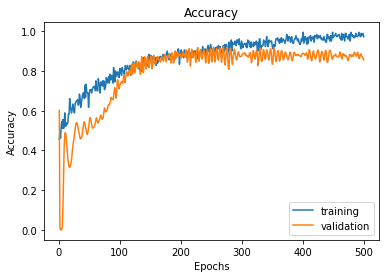

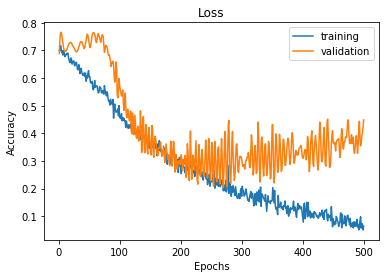

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      4910
           1       0.00      0.00      0.00         0

   micro avg       0.86      0.86      0.86      4910
   macro avg       0.50      0.43      0.46      4910
weighted avg       1.00      0.86      0.92      4910

[[4200  710]
 [   0    0]]


,処理時間,TestLoss,TestAccuracy,F1スコア(micro),エポック数,バッチサイズ,クラス数,学習枚数,評価枚数,データ拡大
0,147.4014,0.4485,0.8554,0.8554,500,10000,2,180,1,True


1ループ終了
全データ表示


,処理時間,TestLoss,TestAccuracy,F1スコア(micro),エポック数,バッチサイズ,クラス数,学習枚数,評価枚数,データ拡大
0,147.4014,0.4485,0.8554,0.8554,500,10000,2,180,1,True


終了しました


In [141]:
# 学習実行用、バッチサイズ、エポックパラメータを複数回処理できるようにしてあります。
def train_process(num_classes, batch_size, epochs, data_aug, verbose, result_df, lr_num):
    for i in range(len(batch_size)):
        batch_size_num = batch_size[i]
        for i in range(len(epochs)):
            epochs_num = epochs[i]
            Test_score_avg = []
            Test_accu_avg = []
            Test_f1_avg = []
            Process_time = []
            for i in range(train_num):
                if train_num > 1:
                    print(train_num, '回繰り返し学習実行後、平均値を算出します')
                print('学習中')
                start = time.time()
                result = train_core(num_classes, batch_size_num,
                                    epochs_num, data_aug, verbose,
                                    lr_num)
                Test_score_avg.append(result[0])
                Test_accu_avg.append(result[1])
                Test_f1_avg.append(result[2])
                elapsed_time = time.time() - start
                
            Process_time.append(elapsed_time)
            Process_time = round(sum(Process_time)/len(Process_time),4)
            Test_score_avg = round(sum(Test_score_avg)/len(Test_score_avg),4)
            Test_accu_avg = round(sum(Test_accu_avg)/len(Test_accu_avg),4)
            Test_f1_avg = round(sum(Test_f1_avg)/len(Test_f1_avg),4)
            show_index = train_disc(Process_time, Test_score_avg, Test_accu_avg, Test_f1_avg, 
                                        epochs_num, batch_size_num, num_classes, 
                                        train_pics, test_pics, data_aug, result_df)  
            temp_df = pd.DataFrame(show_index, columns=column)
            display(temp_df)
            result_df = result_df.append(show_index[0], ignore_index=True)
            print('1ループ終了')

    print('全データ表示')
    display(result_df)

#グラフデータ作成用
#  結果リストデータセット
def train_disc(elapsed_time, result_s, result_a, result_f,
               epochs, batch_size, num_classes,
               train_pics, test_pics, data_aug, result_df):
    data = [elapsed_time, result_s, result_a, result_f,
            epochs, batch_size, num_classes, 
            train_pics, test_pics, data_aug]
    new_data = pd.Series(data, index=result_df.columns)
    return[new_data]
column = ['処理時間', 'TestLoss', 'TestAccuracy', 'F1スコア(micro)',
          'エポック数', 'バッチサイズ', 'クラス数',
          '学習枚数', '評価枚数', 'データ拡大']
result_df = pd.DataFrame( columns=column)    

# 学習パラメータ
num_classes=len(class_folder) # 分類項目数
train_num = 1 # 学習繰り返し数(平均スコア算出の為)
verbose = 0
epochs = [500]
batch_size = [10000]
data_aug = True
lr_num = 0.0001

params = [num_classes, batch_size,
          epochs, data_aug,
          verbose, result_df, lr_num]
# 学習実行
train_process(*params)

print('終了しました')